# #Kaggle_Quora Question Pairs_17.4.14

![quora](./assets/quora.png)
##### Team member: 윤주성, 김성훈, 연재민, 윤성준
##### https://www.kaggle.com/c/quora-question-pairs

#### 본 데이터 셋은 Quora에 올라온 질문들이 서로 같은 질문인지 다른 질문인지 파악하는 "Semantic Textual Similariry" Task입니다. 현재 진행중인 competition에1,508팀, 1,665명의 참가자가 등록된 상태입니다.

### 참고자료
#### https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb
#### https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
#### https://www.kaggle.com/lystdo/quora-question-pairs/lstm-with-word2vec-embeddings
#### http://ben.bolte.cc/blog/2016/keras-gensim-embeddings.html
#### https://shuuki4.wordpress.com/2016/01/27/word2vec-%EA%B4%80%EB%A0%A8-%EC%9D%B4%EB%A1%A0-%EC%A0%95%EB%A6%AC/

In [1]:
#-*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from pprint import pprint # dic 을 예쁘게 보여주는 프린트문
import re
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adullam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data 분석

In [3]:
import os
#import seaborn as sns #matplotlib기반의 Python visualization Library

#pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('./data'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./data/' + f) / 1000000, 2)) + 'MB')

# File sizes
.DS_Store                     0.01MB
test.csv                      314.02MB
test_small.csv                0.0MB
train.csv                     63.4MB
train_small.csv               0.0MB


In [4]:
print("Load data..")
train = pd.read_csv("./data/train.csv", encoding = 'ISO-8859-1') #column 이름이 속성이 됨!
test = pd.read_csv("./data/test.csv", encoding = 'ISO-8859-1')
print("print dataframe")
train.head(10)

Load data..
print dataframe


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use ã· instead of ã?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


각 데이터 필드의 내용은 다음과 같습니다
##### id: 각 행에 배정된 Id를 의미합니다
##### qid{1, 2}: 각 질문에 대한 고유의 id를 의미합니다
##### question{1, 2}: 질문 내용이 text형태로 저장되어 있습니다
##### is_duplicate: Label을 의미하며 쌍으로 구성된 질문이 서로 유사한지 아닌지를 예측하기 위해 사용됩니다

Question pair의 전체 개수: 404290
유사한 Question pair의 개수: 36.92%
Training 데이터 내의 전체 Question의 개수: 537933
중복된 Question의 개수: 111780



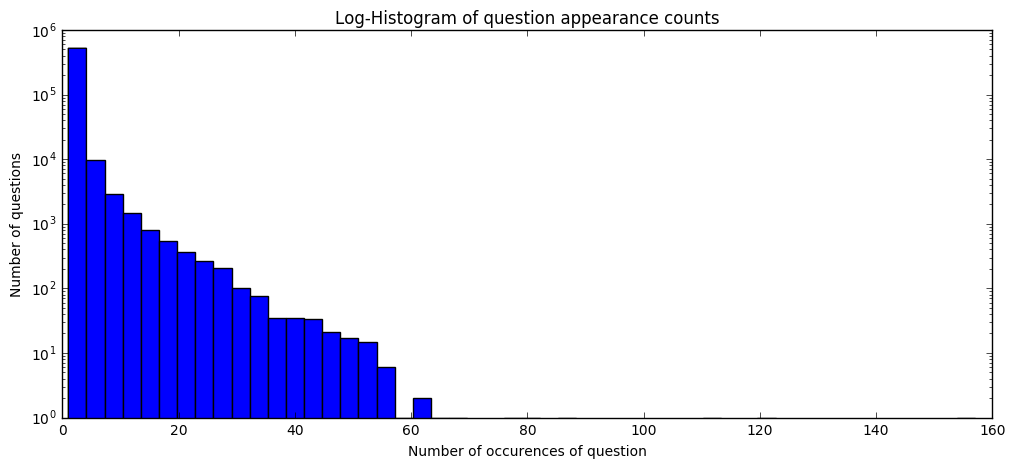

In [5]:
print('Question pair의 전체 개수: {}'.format(len(train)))
print('유사한 Question pair의 개수: {}%'.format(round(train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
print('Training 데이터 내의 전체 Question의 개수: {}'.format(len(
    np.unique(qids))))
print('중복된 Question의 개수: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

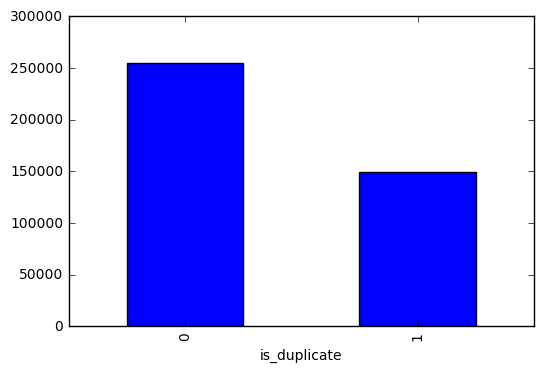

In [13]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

ImportError: No module named 'wordcloud'

### Test Submission

In [7]:
df_test = pd.read_csv('./data/test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


## Preprocessing 시작

In [8]:
print("replace empty data.. with 'empty' token")
train = train.fillna('empty') # 엑셀 내 빈칸을 'empty' 토큰으로 채움
test = test.fillna('empty')

replace empty data.. with 'empty' token


In [9]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """

    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)


    return string.strip().lower()

In [10]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in questions:
        # clean_question = clean_str(text_to_wordlist(question))
        clean_question = clean_str(question)
        #print(clean_question)
        question_word = word_tokenize(clean_question)
        #print(question_word)
        question_list.append(question_word)
        if len(question_list) % 100000 == 0:
            progress = len(question_list) / len(dataframe) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [11]:
def get_preprocessed_data():
    train_label = train.is_duplicate

    train_question1 = [] 
    process_questions(train_question1, train.question1, 'train_question1', train)

    train_question2 = []
    process_questions(train_question2, train.question2, 'train_question2', train)

    test_question1 = []
    process_questions(test_question1, test.question1, 'test_question1', test)

    test_question2 = []
    process_questions(test_question2, test.question2, 'test_question2', test)

    # Find the length of questions
    lengths = []
    print("print first sentence")
    print(train_question1[0])
    for question in train_question1:
        lengths.append(len(question))

    for question in train_question2:
        lengths.append(len(question))
    # print(lengths)
    # Create a dataframe so that the values can be inspected
    lengths = pd.DataFrame(lengths, columns=['counts'])  # 각 질문당 length (이거 왜 구했을까?), RNN에서 필요함
    print('lengths of preprocessed sentence')
    print(lengths)
    lengths.counts.describe()

    return train_question1, train_question2, test_question1, test_question2, lengths

### Prerpocessing 끝
### Word2vec & Gensim

In [ ]:
# Word2vec
from nltk.corpus import reuters
docs_en = [reuters.words(i) for i in reuters.fileids()]

texts_en = docs_en # because we loaded tokenized documents in step 1


# gensim의 Word2Vec 함수는 사전을 만드는 단계와 실제로 학습을 하는 단계로 나눠져있다.
# 그냥iterator을 짜버리면 iteration이 끝난 후에 다시 읽으려고 할때 아무것도 읽을 수 없기 때문에
# 나눠서 넘겨줘야한다. 오히려 그렇기 때문에 사실은 사전 생성용 코퍼스와 학습용 코퍼스의 분리도 가능하다.
# model = gensim.models.Word2Vec()
# model.build_vocab(sentences_vocab)
# model.train(sentences_train)


import multiprocessing

config = {
    'min_count': 5,  # 등장 횟수가 5 이하인 단어는 무시
    'size': 50,  # 50차원짜리 벡터스페이스에 embedding
    'sg': 1,  # 0이면 CBOW, 1이면 skip-gram을 사용한다
    'batch_words': 1000,  # 사전을 구축할때 한번에 읽을 단어 수
    'iter': 10,  # 보통 딥러닝에서 말하는 epoch과 비슷한, 반복 횟수
    'workers': multiprocessing.cpu_count(),
}

#model = gensim.models.Word2Vec(**config)
#print(multiprocessing.cpu_count()) #4?
from gensim.models import word2vec
# 타이머 시작
import time
count_t = time.time()
wv_model_en = word2vec.Word2Vec(texts_en[0:1000], size=100, window=5, min_count=5, workers=1) #worker에서 에러가남 # sentences = [["my", "name", "is", "jamie"], ["jamie", "is", "cute"]]
#wv_model_en = word2vec.Word2Vec(texts_en[0:1000], **config)
print('Running Time : %.02f' % (time.time() - count_t))
wv_model_en.init_sims(replace=True) # 트레이닝이 완료되면 init_sims 명령으로 필요없는 메모리를 unload 시킨다.
wv_model_en.save('en_word2vec_50.model')

pprint(wv_model_en.most_similar('president'))
#pprint(wv_model_en.most_similar('secretary'))
#pprint(wv_model_en.most_similar('country'))

### 학습한 word2vec을 { Word : wordId } 의 Key : value 형태로 저장

In [ ]:
import json
weights = wv_model_en.wv.syn0


vocab_path='./voca.json'
vocab = dict([(k, v.index) for k, v in wv_model_en.wv.vocab.items()])
with open(vocab_path, 'w') as f:
    f.write(json.dumps(vocab))

In [19]:
word2vec_pretraining_file = './word2vec/en_word2vec_50.model'
wv_model_en = word2vec.Word2Vec.load(word2vec_pretraining_file)

In [20]:
print(wv_model_en.wv.syn0)
weights = wv_model_en.wv.syn0
print(wv_model_en.wv.index2word) # words 이고. 실제로 word2index 는 없어서 만들어줘야함..

[[ 0.28864726 -0.12675391 -0.12010208 ...,  0.13121274  0.20601472
  -0.1238763 ]
 [ 0.52658176 -0.32439545 -0.70549595 ...,  0.20959997  0.44275898
   0.43929258]
 [ 0.65621948 -0.31136513 -0.70474297 ...,  0.43965858 -0.23705533
   0.1311954 ]
 ..., 
 [ 0.40136909 -0.14528659 -0.27879426 ...,  0.11698998  0.13648097
   0.14729905]
 [ 0.39328852 -0.19792098 -0.13863127 ...,  0.12161417 -0.14185272
   0.21395299]
 [ 0.23769324 -0.12297292  0.15216458 ...,  0.10636744  0.0378337
   0.13614935]]
['!', 'i', 'to', 'the', 'a', '\\', 'my', "'", 'you', 'and', 'it', 'is', '?', 'in', 'for', 'of', 's', 'on', "n't", 'that', 'me', 'have', 'so', 'just', "i'm", 'with', 'at', 'be', 'do', 'was', 'but', 'not', 'this', 'up', 'day', 'good', 'now', 'out', 'get', 'are', 'all', 'like', 'no', 'go', 'going', 'quot', 'today', 'your', 'love', 'work', 'got', 'we', 'too', 'u', 'from', 'what', 'lol', 'back', 'time', 'about', 'im', 'one', 'will', 'had', 'am', 'know', 'really', 'see', 'amp', 'can', 'ca', 'new', 'som

### Tensorflow Embedding Projector 코드 부분 (Word2vec Visualization)

In [22]:
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib.tensorboard.plugins import projector

embedding_var = tf.Variable(weights, name='embedding')


sess = tf.InteractiveSession()

tf.global_variables_initializer().run()
saver = tf.train.Saver()

log_dir = 'logs/'
saver.save(sess, save_path=log_dir+'model.ckpt', global_step=None)

# TODO: add embedding data
summary_writer = tf.summary.FileWriter(logdir=log_dir, graph=tf.get_default_graph())
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# TODO: add label data
metadata_path = 'logs/metadata.tsv'
with open(metadata_path, 'w') as f:
    for i, label in enumerate(wv_model_en.wv.index2word):
        f.write('{}\n'.format(label))
embedding.metadata_path = metadata_path


# TODO: visualize embedding projector
projector.visualize_embeddings(summary_writer, config)

### Training 부분

In [ ]:

import tensorflow as tf
import numpy as np
tf.set_random_seed(777)  # reproducibility


# hyper parameters

# question1 = "What is the step by step guide to invest in share market in india?"
# question2 = "What is the step by step guide to invest in share market?"

hidden_size =  100 # RNN hidden size
num_classes = 2  # final output size (RNN or softmax, etc.)
batch_size = 1  # one sample data, one batch
sequence_length = 40  # number of lstm rollings (unit #) #padding 이슈..!
w2v_dim = 50

seq_length_1 = tf.placeholder(tf.int32) #http://stackoverflow.com/questions/34670112/tensorflow-rnn-with-varying-length-sentences
seq_length_2 = tf.placeholder(tf.int32)
X_train1 = tf.placeholder(tf.float32, [None, sequence_length, w2v_dim])  # X data
X_train2 = tf.placeholder(tf.float32, [None, sequence_length, w2v_dim])  # X data
Y_label = tf.placeholder(tf.float32, [None, num_classes])  # Y label



# RNN
def lstm(x_input, sequence_length, mode='train'):
    with tf.variable_scope('lstm') as scope:
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True) #state_is_tuple=True, 이게 뭘까
        #if mode == 'train':
        #    lstm_cell = tf.nn.rnn_cell.DropoutWrapper(cell=lstm_cell, output_keep_prob=0.8)
        initial_state = lstm_cell.zero_state(batch_size, tf.float32)
        outputs, _states = tf.nn.dynamic_rnn(lstm_cell,
                                             x_input,
                                             initial_state=initial_state,
                                             dtype=tf.float32,
                                             sequence_length=sequence_length)

# FC layer
    #with tf.variable_scope('logits'):
        # X_for_fc = tf.reshape(outputs, [-1, hidden_size]) # rnn 의 아웃풋 Dim은 어떻게 정하나?
        # fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
        # fc_b = tf.get_variable("fc_b", [num_classes])
        # outputs = tf.matmul(X_for_fc, fc_w) + fc_b # 각 time step 당 아웃풋 결과 계산
        output_end = tf.reshape(outputs[:, -1, :], [-1, hidden_size])  # 마지막 output만 쏙 빼서
    return output_end

# softmax layer (rnn_hidden_size -> num_classes)
# softmax_w = tf.get_variable("softmax_w", [hidden_size, num_classes])
# softmax_b = tf.get_variable("softmax_b", [num_classes])
# outputs = tf.matmul(X_for_softmax, softmax_w) + softmax_b

# expend the data (revive the batches)
output_end1 = lstm(X_train1, seq_length_1)
tf.get_variable_scope().reuse_variables() # or scope.resue_variables() # 현재 변수 범위는 tf.get_variable_scope()를 사용해서 회수
output_end2 = lstm(X_train2, seq_length_2)

output_concat = tf.concat([output_end1, output_end2], 1)
X_for_fc = tf.reshape(output_concat, [-1, hidden_size*2])  # rnn 의 아웃풋 Dim은 어떻게 정하나?
fc_w = tf.Variable(tf.zeros([hidden_size*2, num_classes]), name="fc_w")
fc_b = tf.Variable(tf.zeros([num_classes]), name="fc_b")
outputs = tf.nn.softmax(tf.matmul(X_for_fc, fc_w) + fc_b)  # 각 time step 당 아웃풋 결과 계산

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

print("Y_label")
print(Y_label)
print("outputs")
print(outputs)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(outputs*tf.log(Y_label), axis=1))
loss = cross_entropy

#loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=outputs, labels=Y_label))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss) #RMSPropOptimizer 이게 없다니...

correct_prediction = tf.equal(tf.argmax(Y_label, 1), tf.argmax(outputs, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 아래는 시퀀셜한 아웃풋이 있을때 쓰이는 코드
# Compute sequence cost/loss
# outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
# weights = tf.ones([batch_size, sequence_length])
# sequence_loss = tf.contrib.seq2seq.sequence_loss(
#     logits=reshape_output, targets=Y_label, weights=weights)
# loss = tf.reduce_mean(sequence_loss)  # mean all sequence loss
# train = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

# prediction = tf.argmax(outputs, axis=2)

def text_batch2vec(text_list): # 다음부턴 embedding_lookup table을 쓰자.. 패딩도 넣어주고 그게 훨씬낫겟네
    vector_batch = []
    idx = 0
    for text in text_list:
        vector_list = list()
        for word in text:
           # print(word)
            if word not in wv_model_en.wv.vocab:
                continue
            else:
                vector_list.append(wv_model_en.wv[word])
        vector_batch.append(vector_list)
        idx = idx + 1
    vector_batch = np.pad(vector_batch, [(0,0,0), (0,sequence_length-idx)], mode='constant') # 패딩과의 전쟁
    # batched_data = tf.train.batch(
    #     tensors=[y],
    #     batch_size=5,
    #     dynamic_pad=True,
    #     name="y_batch"
    # )
# https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767 여기 들어가보자
    return vector_batch

#lengths_q1 = lengths_q1.tolist()
#lengths_q2 = lengths_q2.tolist()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(3000):

        train_question1[i*batch_size:(i+1)*batch_size][:]

        x_train1_batch = text_batch2vec( train_question1[i*batch_size:(i+1)*batch_size][:])#text_batch2vec(train_question1[i*batch_size : (i+1)*batch_size, :])
        x_train2_batch = text_batch2vec( train_question2[i*batch_size:(i+1)*batch_size][:])
        pp.pprint((x_train1_batch))
        #pp.pprint((x_train2_batch))

        print("train_label_list")
        pp.pprint(train_label_list[i*batch_size : (i+1)*batch_size][:])
        #print("lengths_q1.counts[i*batch_size : (i+1)*batch_size]")
        pp.pprint(lengths_q1[i*batch_size : (i+1)*batch_size])
        pp.pprint(lengths_q2[i * batch_size: (i + 1) * batch_size])

        feed_dict = { X_train1: x_train1_batch,
                      X_train2: x_train2_batch ,
                      Y_label: train_label_list[i*batch_size : (i+1)*batch_size][:],
                      seq_length_1:lengths_q1[i*batch_size : (i+1)*batch_size],
                      seq_length_2: lengths_q2[i * batch_size: (i + 1) * batch_size]}
        loss, _ = sess.run([loss, optimizer], feed_dict=feed_dict)
        if i % 100 == 0:
            acc = sess.run(accuracy, feed_dict=feed_dict)
            print(i, "loss:", loss, "Accuracy:", acc)


## Future work
### 1. Data analysis
### 2. Tensorflow RNN 